### Problem Description

Broadband company that is now seeing a lot of customer churn due to customer dissatisfaction
because of broadband outages. The company has now curated a dataset, where it tracks several variables that it believes
impact the `outage_duration`. They have tracked three different outage durations, `0` for
no outage, `1` for short outages that last anywhere between a few minutes and a maximum
of 2 hours, and `2` for long outages that can last from 2 hours to sometimes even a couple
of days. Using the metrics that the company has tracked now want to create a machine learning model that will be able to predict the `outage_duration` so that the company can better handle outages and improve customer satisfaction and therefore reduce customer churn.

### Importing all Required Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import sklearn

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, precision_score

import warnings
warnings.filterwarnings('ignore')

import plotly
import plotly.offline as pyoff
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go

from numpy import asarray
from numpy import savetxt
from numpy import loadtxt

Using TensorFlow backend.


### Reading the Train dataset

In [2]:
data = pd.read_csv("data5.csv", sep=',', header=0)

### Train Data Description

In [3]:
print(data.shape)
print(list(data.columns))
print((data.dtypes))

(5904, 28)
['id', 'area_code', 'int_area_code', 'Count_of_area', 'Count_of_broadband_type', 'broadband_type', 'bb_type', 'outage_type', 'Count_of_transit_server_type', 'server_type', 'transit_type', 'log_report', 'count_of_log', 'Sum_of_logs', 'Count_of_log_report_type', 'sum_area_vol', 'Average_of_Volume_frm_area', 'StdDev_of_Volume_frm_area', 'Min_of_Volume_frm_area', 'Max_of_Volume_frm_area', 'Median_of_Volume_frm_area', 'Sum_of_volume', 'Average_of_volume', 'StdDev_of_volume', 'Min_of_volume', 'Max_of_volume', 'Median_of_volume', 'outage_duration']
id                               int64
area_code                        int64
int_area_code                    int64
Count_of_area                    int64
Count_of_broadband_type          int64
broadband_type                  object
bb_type                         object
outage_type                      int64
Count_of_transit_server_type     int64
server_type                     object
transit_type                    object
log_report  

### Correlation on Numerical attributes 

In [4]:
corr=data.corr()
print(corr)

                                    id  area_code  int_area_code  \
id                            1.000000  -0.014969      -0.014969   
area_code                    -0.014969   1.000000       1.000000   
int_area_code                -0.014969   1.000000       1.000000   
Count_of_area                 0.004802   0.121512       0.121512   
Count_of_broadband_type       0.001319   0.086650       0.086650   
outage_type                   0.007085  -0.327441      -0.327441   
Count_of_transit_server_type  0.004300  -0.255801      -0.255801   
count_of_log                 -0.008254  -0.303062      -0.303062   
Sum_of_logs                  -0.009208  -0.370847      -0.370847   
Count_of_log_report_type     -0.006773  -0.227221      -0.227221   
sum_area_vol                  0.005088  -0.122831      -0.122831   
Average_of_Volume_frm_area    0.018000   0.030081       0.030081   
StdDev_of_Volume_frm_area     0.000333   0.088526       0.088526   
Min_of_Volume_frm_area        0.024466  -0.01810

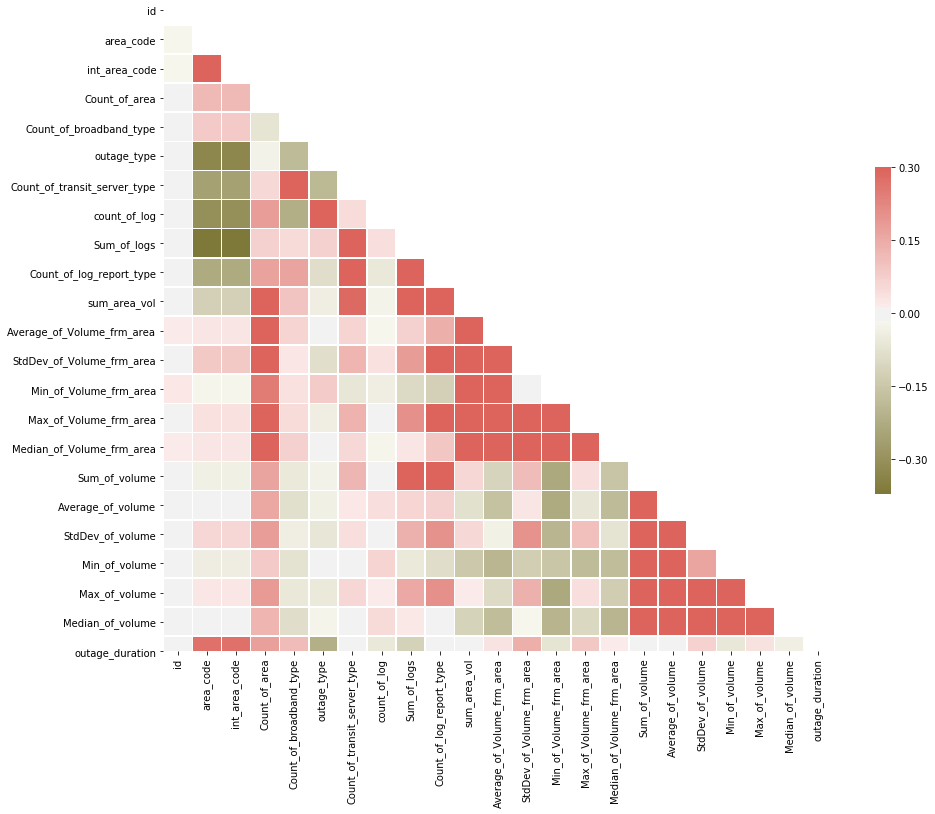

In [5]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(800, 14, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Train Data Preprocessing

In [6]:
data.drop("id", axis = 1, inplace= True) 


data['area_code'] = data['area_code'].astype('category')
data['broadband_type'] = data['broadband_type'].astype('category')
data['bb_type'] = data['bb_type'].astype('category')
data['server_type'] = data['server_type'].astype('category')
data['transit_type'] = data['transit_type'].astype('category')
data['log_report'] = data['log_report'].astype('category')
data['outage_duration'] = data['outage_duration'].astype('category')


print(data.shape)
print(list(data.columns))
print((data.dtypes))

(5904, 27)
['area_code', 'int_area_code', 'Count_of_area', 'Count_of_broadband_type', 'broadband_type', 'bb_type', 'outage_type', 'Count_of_transit_server_type', 'server_type', 'transit_type', 'log_report', 'count_of_log', 'Sum_of_logs', 'Count_of_log_report_type', 'sum_area_vol', 'Average_of_Volume_frm_area', 'StdDev_of_Volume_frm_area', 'Min_of_Volume_frm_area', 'Max_of_Volume_frm_area', 'Median_of_Volume_frm_area', 'Sum_of_volume', 'Average_of_volume', 'StdDev_of_volume', 'Min_of_volume', 'Max_of_volume', 'Median_of_volume', 'outage_duration']
area_code                       category
int_area_code                      int64
Count_of_area                      int64
Count_of_broadband_type            int64
broadband_type                  category
bb_type                         category
outage_type                        int64
Count_of_transit_server_type       int64
server_type                     category
transit_type                    category
log_report                      categ

### Description of Categorical Attributes

In [7]:
data.describe(include='category')

,area_code,broadband_type,bb_type,server_type,transit_type,log_report,outage_duration
count,5904,5904,5904,5904,5904,5904,5904
unique,876,107,5,331,8,2286,3
top,821,_8,only 8,_11,only 34&35,_232_312,0
freq,67,2582,2582,1301,1719,271,3827


### Description of Numerical Attributes

In [8]:
data.describe()

,int_area_code,Count_of_area,Count_of_broadband_type,outage_type,Count_of_transit_server_type,count_of_log,Sum_of_logs,Count_of_log_report_type,sum_area_vol,Average_of_Volume_frm_area,StdDev_of_Volume_frm_area,Min_of_Volume_frm_area,Max_of_Volume_frm_area,Median_of_Volume_frm_area,Sum_of_volume,Average_of_volume,StdDev_of_volume,Min_of_volume,Max_of_volume,Median_of_volume
count,5904.000000,5904.000000,5904.00000,5904.000000,5904.000000,5904.000000,5904.000000,5904.000000,5904.000000,5904.000000,5904.000000,5904.000000,5904.000000,5904.000000,5904.000000,5904.000000,5904.000000,5904.00000,5904.000000,5904.000000
mean,623.909045,24.527270,1.14397,1.656673,1.688347,1959.457317,678.396341,3.217310,34.947154,9.852642,4.426999,6.013550,14.616531,9.418191,32.354505,9.031165,5.162093,4.73357,15.033367,8.090617
std,320.360280,20.899798,0.43784,0.759276,0.723573,1709.499473,646.044988,2.232929,51.267277,10.182194,7.583099,7.553198,16.735508,10.487947,81.161794,21.531079,16.047574,14.74172,37.773293,20.997715
min,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.00000,1.000000,1.000000
25%,375.000000,8.000000,1.00000,1.000000,1.000000,564.000000,281.000000,2.000000,6.000000,3.000000,0.000000,2.000000,3.000000,3.000000,3.000000,1.000000,0.000000,1.00000,2.000000,1.000000
50%,661.000000,19.000000,1.00000,2.000000,2.000000,1419.000000,537.000000,2.000000,16.000000,6.000000,1.000000,4.000000,8.000000,6.000000,8.000000,3.000000,1.000000,1.00000,4.000000,3.000000
75%,892.000000,36.000000,1.00000,2.000000,2.000000,3472.000000,862.250000,4.000000,42.000000,13.000000,6.000000,7.000000,19.000000,13.000000,26.000000,8.000000,4.000000,3.00000,13.000000,7.000000
max,1126.000000,85.000000,5.00000,5.000000,9.000000,5267.000000,5203.000000,19.000000,686.000000,75.000000,56.000000,75.000000,85.000000,85.000000,1649.000000,412.000000,423.000000,354.00000,877.000000,574.000000


### Distribution of Target Attribute

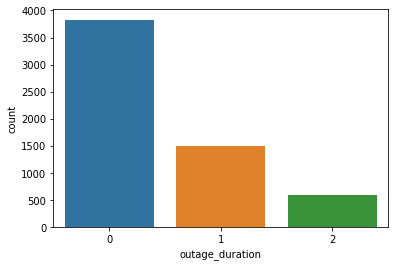

0    3827
1    1496
2     581
Name: outage_duration, dtype: int64


In [9]:
sns.countplot(x='outage_duration',data=data)
plt.show()

# What are the counts?
print(data.outage_duration.value_counts())

### Dividing the Numerical and categorical values

In [10]:
cat_attr = list(data.select_dtypes("category").columns)
num_attr = list(data.columns.difference(cat_attr))

cat_attr.remove('outage_duration')  # Removing the target Variable

In [11]:
cat_attr

['area_code',
 'broadband_type',
 'bb_type',
 'server_type',
 'transit_type',
 'log_report']

In [12]:
num_attr

['Average_of_Volume_frm_area',
 'Average_of_volume',
 'Count_of_area',
 'Count_of_broadband_type',
 'Count_of_log_report_type',
 'Count_of_transit_server_type',
 'Max_of_Volume_frm_area',
 'Max_of_volume',
 'Median_of_Volume_frm_area',
 'Median_of_volume',
 'Min_of_Volume_frm_area',
 'Min_of_volume',
 'StdDev_of_Volume_frm_area',
 'StdDev_of_volume',
 'Sum_of_logs',
 'Sum_of_volume',
 'count_of_log',
 'int_area_code',
 'outage_type',
 'sum_area_vol']

### Train And Test Split

In [13]:
y = data['outage_duration']
x=data.drop('outage_duration',axis=1)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.30)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(4132, 26)
(1772, 26)
(4132,)
(1772,)


### Pipeline Intialization 

In [14]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, num_attr),
        ('cat', categorical_transformer, cat_attr)
])

### Data Preprocessing in the Pipeline

In [15]:
clf = Pipeline(steps=[('preprocessor', preprocessor)])

x_train_pp = pd.DataFrame(clf.fit_transform(x_train).toarray())
x_test_pp = pd.DataFrame(clf.transform(x_test).toarray())

### Handling the Imbalance Problem using SMOTE

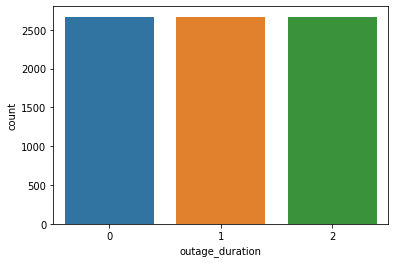

2    2668
1    2668
0    2668
Name: outage_duration, dtype: int64


In [16]:
smote = SMOTE(random_state=0)


os_train_x,os_train_y=smote.fit_sample(x_train_pp, y_train)

os_train_x = pd.DataFrame(data=os_train_x)
os_train_y= pd.DataFrame(data=os_train_y,columns=['outage_duration'])

sns.countplot(x='outage_duration',data=os_train_y)
plt.show()

# What are the counts?
print(os_train_y.outage_duration.value_counts())

# Model Building:

### Model 1 Logistic Regression

In [17]:
clf_logreg = Pipeline(steps=[('classifier', LogisticRegression(random_state=123))])

clf_logreg.fit(os_train_x,os_train_y)

train_pred = clf_logreg.predict(os_train_x).reshape(1,-1)[0]
test_pred = clf_logreg.predict(x_test_pp).reshape(1,-1)[0]

train_pred_lr = train_pred
test_pred_lr= test_pred


print("Train Data:")
print("Confusion matrix Train:")
print("-----------------------")
print(metrics.confusion_matrix(os_train_y,train_pred))
print("-------------------------------------------------------------------------------------------------------")
print(metrics.classification_report(os_train_y,train_pred, digits=3))

print("*******************************************************************************************************")

print("Test Data:")
print("Confusion matrix Test:")
print("----------------------")
print(metrics.confusion_matrix(y_test,test_pred))
print("-------------------------------------------------------------------------------------------------------")
print(metrics.classification_report(y_test,test_pred, digits=3))




Train Data:
Confusion matrix Train:
-----------------------
[[2342  202  124]
 [  81 2439  148]
 [  23   23 2622]]
-------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.957     0.878     0.916      2668
           1      0.916     0.914     0.915      2668
           2      0.906     0.983     0.943      2668

    accuracy                          0.925      8004
   macro avg      0.926     0.925     0.925      8004
weighted avg      0.926     0.925     0.925      8004

*******************************************************************************************************
Test Data:
Confusion matrix Test:
----------------------
[[882 207  70]
 [119 278  66]
 [ 19  37  94]]
-------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.865     0.761 

###  Model 2 Random Forest

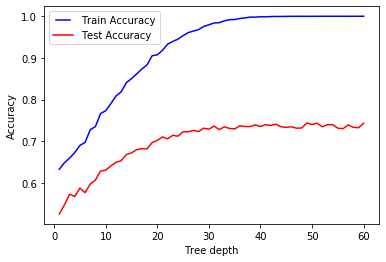

In [18]:
from sklearn import tree

max_depths = np.linspace(1, 60, 60, endpoint=True)

train_results = []
test_results = []

for max_depth in max_depths:
    rf = Pipeline(steps=[('classifier', RandomForestClassifier(max_depth=max_depth))])
    rf.set_params(classifier__random_state=123)
    #dt = tree.DecisionTreeClassifier(max_depth=max_depth)
    rf.fit(os_train_x,os_train_y)
    
    train_pred = rf.predict(os_train_x).reshape(1,-1)[0]
    confusion_matrix_train = confusion_matrix(os_train_y,train_pred)
    Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1]+confusion_matrix_train[2,2])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[0,2]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1]+confusion_matrix_train[1,2]+confusion_matrix_train[2,0]+confusion_matrix_train[2,1]+confusion_matrix_train[2,2])    
    train_results.append(Accuracy_Train)
    
    test_pred = rf.predict(x_test_pp).reshape(1,-1)[0]
    confusion_matrix_test = confusion_matrix(y_test, test_pred)
    Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1]+confusion_matrix_test[2,2])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[0,2]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1]+confusion_matrix_test[1,2]+confusion_matrix_test[2,0]+confusion_matrix_test[2,1]+confusion_matrix_test[2,2])    
    test_results.append(Accuracy_Test)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results,'b', label='Train Accuracy')
line2, = plt.plot(max_depths, test_results,'r', label='Test Accuracy')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('Tree depth')
plt.show()

In [19]:
#After plotting the graph deciding the max Depth and building a model in Random forest


from sklearn import tree

clf_rf2 = Pipeline(steps=[('classifier', RandomForestClassifier())])

clf_rf2_param_random = {'classifier__criterion': ['entropy','gini'], 
                'classifier__max_depth':[30,31]}


clf_rf2_random = RandomizedSearchCV(clf_rf2, param_distributions=clf_rf2_param_random,cv=10,random_state=123)


#clf_dt2.set_params(classifier__criterion ='entropy',classifier__max_depth=15,classifier__random_state=123)

clf_rf2_random.fit(os_train_x,os_train_y)

print(clf_rf2_random.best_params_)

train_pred = clf_rf2_random.predict(os_train_x).reshape(1,-1)[0]
test_pred = clf_rf2_random.predict(x_test_pp).reshape(1,-1)[0]

train_pred_rf = train_pred
test_pred_rf= test_pred

print("Train Data:")
print("Confusion matrix Train:")
print("-----------------------")
print(metrics.confusion_matrix(os_train_y,train_pred))
print("-------------------------------------------------------------------------------------------------------")
print(metrics.classification_report(os_train_y,train_pred, digits=3))

print("*******************************************************************************************************")

print("Test Data:")
print("Confusion matrix Test:")
print("----------------------")
print(metrics.confusion_matrix(y_test,test_pred))
print("-------------------------------------------------------------------------------------------------------")
print(metrics.classification_report(y_test,test_pred, digits=3))

{'classifier__max_depth': 31, 'classifier__criterion': 'entropy'}
Train Data:
Confusion matrix Train:
-----------------------
[[2580   74   14]
 [   5 2660    3]
 [   0    0 2668]]
-------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.998     0.967     0.982      2668
           1      0.973     0.997     0.985      2668
           2      0.994     1.000     0.997      2668

    accuracy                          0.988      8004
   macro avg      0.988     0.988     0.988      8004
weighted avg      0.988     0.988     0.988      8004

*******************************************************************************************************
Test Data:
Confusion matrix Test:
----------------------
[[917 179  63]
 [148 267  48]
 [ 18  14 118]]
-------------------------------------------------------------------------------------------------------
              precision

### Model 3 Knn

In [20]:
clf_knn = Pipeline(steps=[('classifier', KNeighborsClassifier())])

clf_knn.set_params(classifier__n_neighbors=2)


clf_knn.fit(os_train_x,os_train_y)

train_pred = clf_knn.predict(os_train_x).reshape(1,-1)[0]
test_pred = clf_knn.predict(x_test_pp).reshape(1,-1)[0]

train_pred_knn = train_pred
test_pred_knn= test_pred

print("Train Data:")
print("Confusion matrix Train:")
print("-----------------------")
print(metrics.confusion_matrix(os_train_y,train_pred))
print("-------------------------------------------------------------------------------------------------------")
print(metrics.classification_report(os_train_y,train_pred, digits=3))

print("*******************************************************************************************************")

print("Test Data:")
print("Confusion matrix Test:")
print("----------------------")
print(metrics.confusion_matrix(y_test,test_pred))
print("-------------------------------------------------------------------------------------------------------")
print(metrics.classification_report(y_test,test_pred, digits=3))

Train Data:
Confusion matrix Train:
-----------------------
[[2668    0    0]
 [  63 2605    0]
 [   3    8 2657]]
-------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.976     1.000     0.988      2668
           1      0.997     0.976     0.987      2668
           2      1.000     0.996     0.998      2668

    accuracy                          0.991      8004
   macro avg      0.991     0.991     0.991      8004
weighted avg      0.991     0.991     0.991      8004

*******************************************************************************************************
Test Data:
Confusion matrix Test:
----------------------
[[825 274  60]
 [132 272  59]
 [ 36  38  76]]
-------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.831     0.712 

### Model 4 SVC

In [21]:
clf_svc3 = Pipeline(steps=[('classifier', SVC())])


svc3_param_random = {'classifier__C': [1], 
                  'classifier__gamma':[0.001], 
                 "classifier__kernel":['linear']}


svc3_random = RandomizedSearchCV(clf_svc3, param_distributions=svc3_param_random, cv=5,random_state=123)


#clf_svc2.set_params(classifier__kernel='rbf',classifier__C=1,classifier__gamma=0.001,classifier__random_state=123)

svc3_random.fit(os_train_x,os_train_y)

train_pred = svc3_random.predict(os_train_x).reshape(1,-1)[0]
test_pred = svc3_random.predict(x_test_pp).reshape(1,-1)[0]

train_pred_svc = train_pred
test_pred_svc= test_pred

print(svc3_random.best_params_)
print("Train Data:")
print("Confusion matrix Train:")
print("-----------------------")
print(metrics.confusion_matrix(os_train_y,train_pred))
print("-------------------------------------------------------------------------------------------------------")
print(metrics.classification_report(os_train_y,train_pred, digits=3))

print("*******************************************************************************************************")

print("Test Data:")
print("Confusion matrix Test:")
print("----------------------")
print(metrics.confusion_matrix(y_test,test_pred))
print("-------------------------------------------------------------------------------------------------------")
print(metrics.classification_report(y_test,test_pred, digits=3))

{'classifier__kernel': 'linear', 'classifier__gamma': 0.001, 'classifier__C': 1}
Train Data:
Confusion matrix Train:
-----------------------
[[2386  186   96]
 [  68 2473  127]
 [  16   18 2634]]
-------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.966     0.894     0.929      2668
           1      0.924     0.927     0.925      2668
           2      0.922     0.987     0.953      2668

    accuracy                          0.936      8004
   macro avg      0.937     0.936     0.936      8004
weighted avg      0.937     0.936     0.936      8004

*******************************************************************************************************
Test Data:
Confusion matrix Test:
----------------------
[[918 189  52]
 [140 264  59]
 [ 26  36  88]]
-------------------------------------------------------------------------------------------------------
        

### Model 5 ADA Boosting

In [22]:
from sklearn import tree
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

clf_ada1 = Pipeline(steps=[('classifier', AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=31,criterion='entropy')))])

clf_ada1.set_params(classifier__n_estimators=600,classifier__learning_rate=1,classifier__random_state=123)


#clf_dt2.set_params(classifier__criterion ='entropy',classifier__max_depth=15,classifier__random_state=123)

clf_ada1.fit(os_train_x,os_train_y)


train_pred = clf_ada1.predict(os_train_x).reshape(1,-1)[0]
test_pred = clf_ada1.predict(x_test_pp).reshape(1,-1)[0]

train_pred_ada = train_pred
test_pred_ada= test_pred

print("Train Data:")
print("Confusion matrix Train:")
print("-----------------------")
print(metrics.confusion_matrix(os_train_y,train_pred))
print("-------------------------------------------------------------------------------------------------------")
print(metrics.classification_report(os_train_y,train_pred, digits=3))

print("*******************************************************************************************************")

print("Test Data:")
print("Confusion matrix Test:")
print("----------------------")
print(metrics.confusion_matrix(y_test,test_pred))
print("-------------------------------------------------------------------------------------------------------")
print(metrics.classification_report(y_test,test_pred, digits=3))

Train Data:
Confusion matrix Train:
-----------------------
[[2668    0    0]
 [   2 2666    0]
 [   0    0 2668]]
-------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.999     1.000     1.000      2668
           1      1.000     0.999     1.000      2668
           2      1.000     1.000     1.000      2668

    accuracy                          1.000      8004
   macro avg      1.000     1.000     1.000      8004
weighted avg      1.000     1.000     1.000      8004

*******************************************************************************************************
Test Data:
Confusion matrix Test:
----------------------
[[967 149  43]
 [173 252  38]
 [ 28  18 104]]
-------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.828     0.834 

###  Model 6 Decision Tress

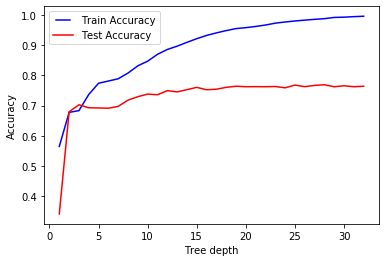

In [23]:
from sklearn import tree

max_depths = np.linspace(1, 32, 32, endpoint=True)

train_results = []
test_results = []

for max_depth in max_depths:
    dt = Pipeline(steps=[('classifier', tree.DecisionTreeClassifier(max_depth=max_depth))])
    dt.set_params(classifier__random_state=123)
    #dt = tree.DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(os_train_x,os_train_y)
    
    train_pred = dt.predict(os_train_x).reshape(1,-1)[0]
    confusion_matrix_train = confusion_matrix(os_train_y,train_pred)
    Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
    train_results.append(Accuracy_Train)
    
    test_pred = dt.predict(x_test_pp).reshape(1,-1)[0]
    confusion_matrix_test = confusion_matrix(y_test, test_pred)
    Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
    test_results.append(Accuracy_Test)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results,'b', label='Train Accuracy')
line2, = plt.plot(max_depths, test_results,'r', label='Test Accuracy')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('Tree depth')
plt.show()

In [24]:
from sklearn import tree

clf_dt3 = Pipeline(steps=[('classifier', tree.DecisionTreeClassifier())])

clf_dt3_param_random = {'classifier__criterion': ['entropy','gini'], 
                'classifier__max_depth':[15,16,17]}


clf_dt3_random = RandomizedSearchCV(clf_dt3, param_distributions=clf_dt3_param_random,cv=5,random_state=123)


#clf_dt2.set_params(classifier__criterion ='entropy',classifier__max_depth=15,classifier__random_state=123)

clf_dt3_random.fit(os_train_x,os_train_y)

print(clf_dt3_random.best_params_)

train_pred = clf_dt3_random.predict(os_train_x).reshape(1,-1)[0]
test_pred = clf_dt3_random.predict(x_test_pp).reshape(1,-1)[0]

train_pred_dt = train_pred
test_pred_dt= test_pred


print("Train Data:")
print("Confusion matrix Train:")
print("-----------------------")
print(metrics.confusion_matrix(os_train_y,train_pred))
print("-------------------------------------------------------------------------------------------------------")
print(metrics.classification_report(os_train_y,train_pred, digits=3))

print("*******************************************************************************************************")

print("Test Data:")
print("Confusion matrix Test:")
print("----------------------")
print(metrics.confusion_matrix(y_test,test_pred))
print("-------------------------------------------------------------------------------------------------------")
print(metrics.classification_report(y_test,test_pred, digits=3))

{'classifier__max_depth': 17, 'classifier__criterion': 'gini'}
Train Data:
Confusion matrix Train:
-----------------------
[[2329  232  107]
 [  74 2487  107]
 [  18   30 2620]]
-------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.962     0.873     0.915      2668
           1      0.905     0.932     0.918      2668
           2      0.924     0.982     0.952      2668

    accuracy                          0.929      8004
   macro avg      0.930     0.929     0.929      8004
weighted avg      0.930     0.929     0.929      8004

*******************************************************************************************************
Test Data:
Confusion matrix Test:
----------------------
[[860 221  78]
 [142 266  55]
 [ 25  26  99]]
-------------------------------------------------------------------------------------------------------
              precision   

### Model 7 XG Boosting

In [25]:
#XGB_model = XGBClassifier(n_estimators=500, gamma=0.5,learning_rate=0.1)
#%time XGB_model.fit(X_train, y_train)
#y_pred = XGB_model.predict(X_test)
#print(accuracy_score(y_test,y_pred))


from xgboost import XGBClassifier
clf_xg = Pipeline(steps=[('classifier', XGBClassifier(n_estimators=500, gamma=0,learning_rate=0.1,max_depth=4))])


clf_xg.fit(os_train_x,os_train_y)

train_pred = clf_xg.predict(os_train_x).reshape(1,-1)[0]
test_pred = clf_xg.predict(x_test_pp).reshape(1,-1)[0]

train_pred_xg = train_pred
test_pred_xg= test_pred

print("Train Data:")
print("Confusion matrix Train:")
print("-----------------------")
print(metrics.confusion_matrix(os_train_y,train_pred))
print("-------------------------------------------------------------------------------------------------------")
print(metrics.classification_report(os_train_y,train_pred, digits=3))

print("*******************************************************************************************************")

print("Test Data:")
print("Confusion matrix Test:")
print("----------------------")
print(metrics.confusion_matrix(y_test,test_pred))
print("-------------------------------------------------------------------------------------------------------")
print(metrics.classification_report(y_test,test_pred, digits=3))

Train Data:
Confusion matrix Train:
-----------------------
[[2316  258   94]
 [ 160 2429   79]
 [  16   13 2639]]
-------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.929     0.868     0.898      2668
           1      0.900     0.910     0.905      2668
           2      0.938     0.989     0.963      2668

    accuracy                          0.923      8004
   macro avg      0.922     0.923     0.922      8004
weighted avg      0.922     0.923     0.922      8004

*******************************************************************************************************
Test Data:
Confusion matrix Test:
----------------------
[[910 185  64]
 [118 304  41]
 [ 25  24 101]]
-------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.864     0.785 

### Reading Test dataset

In [26]:
test = pd.read_csv("test4.csv", sep=',', header=0)
print(test.shape)
print(list(test.columns))

(1477, 27)
['id', 'area_code', 'int_area_code', 'Count_of_area', 'Count_of_broadband_type', 'broadband_type', 'bb_type', 'outage_type', 'Count_of_transit_server_type', 'server_type', 'transit_type', 'log_report', 'count_of_log', 'Sum_of_logs', 'Count_of_log_report_type', 'sum_area_vol', 'Average_of_Volume_frm_area', 'StdDev_of_Volume_frm_area', 'Min_of_Volume_frm_area', 'Max_of_Volume_frm_area', 'Median_of_Volume_frm_area', 'Sum_of_volume', 'Average_of_volume', 'StdDev_of_volume', 'Min_of_volume', 'Max_of_volume', 'Median_of_volume']


### Test data Preprocessing

In [27]:
test.drop("id", axis = 1, inplace= True) 


test['area_code'] = test['area_code'].astype('category')
test['broadband_type'] = test['broadband_type'].astype('category')
test['bb_type'] = test['bb_type'].astype('category')
#test['outage_type'] = test['outage_type'].astype('category') 
test['server_type'] = test['server_type'].astype('category')
test['transit_type'] = test['transit_type'].astype('category')
test['log_report'] = test['log_report'].astype('category')





print(test.shape)
print(list(test.columns))
print((test.dtypes))

cat_attr = list(test.select_dtypes("category").columns)
num_attr = list(test.columns.difference(cat_attr))

(1477, 26)
['area_code', 'int_area_code', 'Count_of_area', 'Count_of_broadband_type', 'broadband_type', 'bb_type', 'outage_type', 'Count_of_transit_server_type', 'server_type', 'transit_type', 'log_report', 'count_of_log', 'Sum_of_logs', 'Count_of_log_report_type', 'sum_area_vol', 'Average_of_Volume_frm_area', 'StdDev_of_Volume_frm_area', 'Min_of_Volume_frm_area', 'Max_of_Volume_frm_area', 'Median_of_Volume_frm_area', 'Sum_of_volume', 'Average_of_volume', 'StdDev_of_volume', 'Min_of_volume', 'Max_of_volume', 'Median_of_volume']
area_code                       category
int_area_code                      int64
Count_of_area                      int64
Count_of_broadband_type            int64
broadband_type                  category
bb_type                         category
outage_type                        int64
Count_of_transit_server_type       int64
server_type                     category
transit_type                    category
log_report                      category
count_of_log   

### Preprocessing Test data in Pipeline

In [28]:
clf = Pipeline(steps=[('preprocessor', preprocessor)])
x_test_unseen = pd.DataFrame(clf.transform(test).toarray())

### Predicting the test data on any above model 

In [29]:
test_pred_unseen = clf_xg.predict(x_test_unseen).reshape(1,-1)[0]  # Predict on whichever model u want

test_pred_unseen2 = pd.DataFrame(test_pred_unseen)

test_pred_unseen2.to_csv("Testoutput.csv")